<a href="https://colab.research.google.com/github/jh17sh21-oss/gendered-racism-dataset/blob/main/TopicModeling_BERT_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall numpy
!pip install bertopic gensim scikit-learn sentence-transformers tqdm openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 2.3.3 which is incompatible.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.3 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.3 which i

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sentence_transformers import SentenceTransformer
from google.colab import files

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

for filename in uploaded:
    if filename.endswith(".xlsx"):
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
    elif filename.endswith(".csv"):
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    else:
        raise ValueError("지원되지 않는 파일 형식입니다. .xlsx 또는 .csv를 사용하세요.")

Saving topic_rawdata.xlsx to topic_rawdata.xlsx


In [ ]:
stopwords = set([
    '그', '이', '저', '것', '등', '때', '중', '누구', '무엇', '하다', '되다', '있다', '없다', '받다',
    '가다', '오다', '보다', '주다', '말하다', '들다', '계속', '이제', '지금', '예전', '요즘', '거의',
    '좀', '많이', '더', '다시', '별로', '그리고', '그래서', '그런데', '하지만', '그러니까', '때문',
    '이런', '그런', '어떤', '같다', '나', '내', '너', '우리', '당신', '그녀', '그들', '사람', '모두',
    '여기', '저기', '거기', '안', '밖', '위', '아래', '그곳', '방향', '도', '는', '만', '과', '와',
    '보다', '까지', '부터', '으로', '에게', '이랑', '밖에', '조차', '정도', '경우', '내용', '문제',
    '이야기', '모습', '상황', '자신', '음', '응', '오', '어휴', '허', '아이고', '에휴', '웃음',
    '그떄', '그다음', '아마', '...', '…', '“', '”', '‘', '’', '-', '--', '―', '그냥', '진짜', '완전',
    '약간', '어떻게', '뭐', '딱', '막', '또', '또는', '해도', '생각', '중략', '가지', '조금',
    '다문화', '중국', '일본', '한국', '우즈베키스탄', '베트남', '태국', '몽골', '몽고',
    '자기', '그때', '그거', '수도', '그게', '여러', '무슨', '네네', '나이', '어디', '먼저', '대부분',
    '나중', '대해', '그것', '뭔가', '전혀', '저희', '만약', '이주', '나가야', '다른', '항상',
    '얘기',
])

standardization_dict = {
    "아빠": "남편", "여자": "여성", "아기": "아이", "한국말": "한국어",
    "시엄마": "시어머니", "어머니": "시어머니", "대한민국": "한국",
    "외국": "외국인", "외국사람": "외국인", "차별적": "차별", "무시당함": "무시",
    "무시함": "무시", "편견들": "편견", "회사": "직장", "업무": "직장",
    "일": "직장", "회사생활": "직장", "말": "언어", "한국사람": "한국인"
}
def clean_text(text):
    words = text.split()
    processed = []
    for word in words:
        word = standardization_dict.get(word, word)
        if word not in stopwords:
            processed.append(word)
    return " ".join(processed)

In [ ]:
docs_cleaned = [
    clean_text(text)
    for text in df["원자료"].dropna().astype(str).tolist()
]

In [ ]:
def preprocess_text(text, stopwords, standardization_dict):
    words = text.split()
    processed = []
    for word in words:
        word = standardization_dict.get(word, word)
        if word not in stopwords:
            processed.append(word)
    return processed

docs_tokenized = [preprocess_text(doc, stopwords, standardization_dict)
    for doc in docs_cleaned]

from gensim.corpora import Dictionary
id2word = Dictionary(docs_tokenized)

In [ ]:
topic_nums = list(range(3, 21))

results = []

embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

for n in tqdm(topic_nums):
    topic_model = BERTopic(
        embedding_model=embedding_model,
        language="multilingual",
        calculate_probabilities=False,
        low_memory=True,
        n_gram_range=(1, 3)
    )

    topics, probs = topic_model.fit_transform(docs_cleaned)

    reduced_model = topic_model.reduce_topics(docs_cleaned, nr_topics=n)

    keywords = [reduced_model.get_topic(i) for i in range(n)]
    keywords = [topic for topic in keywords if topic]
    topic_words = [[word for word, _ in topic] for topic in keywords]

    topic_reprs = reduced_model.topic_embeddings_
    sim_matrix = cosine_similarity(topic_reprs)
    upper_tri = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    similarity = np.mean(upper_tri)
    cosine_distance = 1 - similarity

    cm = CoherenceModel(
        topics=topic_words,
        texts=docs_tokenized,
        dictionary=id2word,
        coherence='c_v',
        processes=1)
    coherence = cm.get_coherence()

    results.append({
        "토픽수": n,
        "코사인거리(Cosine Distance)": cosine_distance,
        "일관성(Coherence)": coherence
    })

results_df = pd.DataFrame(results)
results_df

100%|██████████| 18/18 [10:57<00:00, 36.55s/it]


,토픽수,코사인거리(Cosine Distance),일관성(Coherence)
0,3,0.175118,0.275428
1,4,0.236234,0.291719
2,5,0.283592,0.304225
3,6,0.298645,0.333401
4,7,0.317334,0.320533
5,8,0.011541,0.297234
6,9,0.014158,0.326030
7,10,0.019397,0.331499
8,11,0.017357,0.322253
9,12,0.020917,0.324230


In [ ]:
from google.colab import files

output_path = "/content/토픽수_코사인거리_코히런스결과.xlsx"
results_df.to_excel(output_path, index=False)
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving RawDaTa.xlsx to RawDaTa.xlsx


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

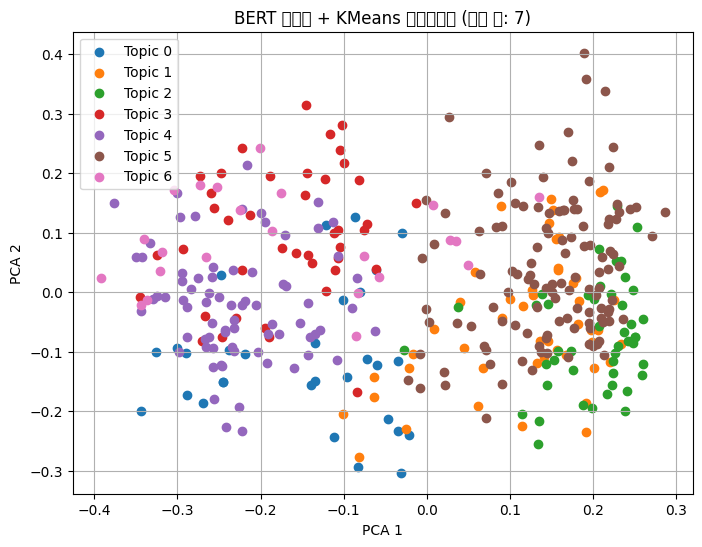

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
!pip install -q sentence-transformers scikit-learn openpyxl

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import io

uploaded = files.upload()

for filename in uploaded:
    if filename.endswith(".xlsx"):
        df = pd.read_excel(io.BytesIO(uploaded[filename]))
    elif filename.endswith(".csv"):
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    else:
        raise ValueError("지원되지 않는 파일 형식입니다.")

stopwords = set([
    '그', '이', '저', '것', '등', '때', '중', '누구', '무엇', '하다', '되다', '있다', '없다', '받다',
    '가다', '오다', '보다', '주다', '말하다', '들다', '계속', '이제', '지금', '예전', '요즘', '거의',
    '좀', '많이', '더', '다시', '별로', '그리고', '그래서', '그런데', '하지만', '그러니까', '때문',
    '이런', '그런', '어떤', '같다', '나', '내', '너', '우리', '당신', '그녀', '그들', '사람', '모두',
    '여기', '저기', '거기', '안', '밖', '위', '아래', '그곳', '방향', '도', '는', '만', '과', '와',
    '보다', '까지', '부터', '으로', '에게', '이랑', '밖에', '조차', '정도', '경우', '내용', '문제',
    '이야기', '모습', '상황', '자신', '음', '응', '오', '어휴', '허', '아이고', '에휴', '웃음',
    '그떄', '그다음', '아마', '...', '…', '“', '”', '‘', '’', '-', '--', '―', '그냥', '진짜', '완전',
    '약간', '어떻게', '뭐', '딱', '막', '또', '또는', '해도', '생각', '중략', '가지', '조금',
    '다문화', '중국', '일본', '한국', '우즈베키스탄', '베트남', '태국', '몽골', '몽고',
    '자기', '그때', '그거', '수도', '그게', '여러', '무슨', '네네', '나이', '어디', '먼저', '대부분',
    '나중', '대해', '그것', '뭔가', '전혀', '저희', '만약', '이주', '나가야', '다른', '항상',
    '얘기', '나라', '부분', '선생님'
])

standardization_dict = {
    "아빠": "남편", "여자": "여성", "아기": "아이", "한국말": "한국어",
    "시엄마": "시어머니", "어머니": "시어머니", "대한민국": "한국",
    "외국": "외국인", "외국사람": "외국인", "차별적": "차별", "무시당함": "무시",
    "무시함": "무시", "편견들": "편견", "회사": "직장", "업무": "직장",
    "일": "직장", "회사생활": "직장", "말": "언어", "한국사람": "한국인"
}

def preprocess_text(text):
    words = text.split()
    cleaned = []
    for word in words:
        word = standardization_dict.get(word, word)
        if word not in stopwords:
            cleaned.append(word)
    return " ".join(cleaned)

sentences = [preprocess_text(doc) for doc in df["원자료"].dropna().astype(str).tolist()]

model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
embeddings = model.encode(sentences)

num_topics = 7
kmeans = KMeans(n_clusters=num_topics, random_state=42)
labels = kmeans.fit_predict(embeddings)

df = df.loc[df["원자료"].notna()].copy()
df["토픽번호"] = labels

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
df["x"] = reduced[:, 0]
df["y"] = reduced[:, 1]

plt.figure(figsize=(8, 6))
for label in sorted(set(labels)):
    subset = df[df["토픽번호"] == label]
    plt.scatter(subset["x"], subset["y"], label=f"Topic {label}")
plt.title("BERT 임베딩 + KMeans 클러스터링 (토픽 수: 7)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

output_path = "/content/최종_토픽_분석결과_7개.xlsx"
df.to_excel(output_path, index=False)
files.download(output_path)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving NanumBarunGothic.ttf to NanumBarunGothic (1).ttf


In [7]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

font_path = "/content/NanumBarunGothic.ttf"
fm.fontManager.addfont(font_path)
font_name = fm.FontProperties(fname=font_path).get_name()

mpl.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [8]:
topic_labels = {
    0: "외모/출신 국가에 대한 편견",
    1: "교육장면에서 발생하는 차별",
    2: "언어에 대한 차별",
    3: "무시와 인격적 경시",
    4: "사회적 배제와 소외시킴",
    5: "제도적 낙인과 의심",
    6: "성역할 고정관념"
}

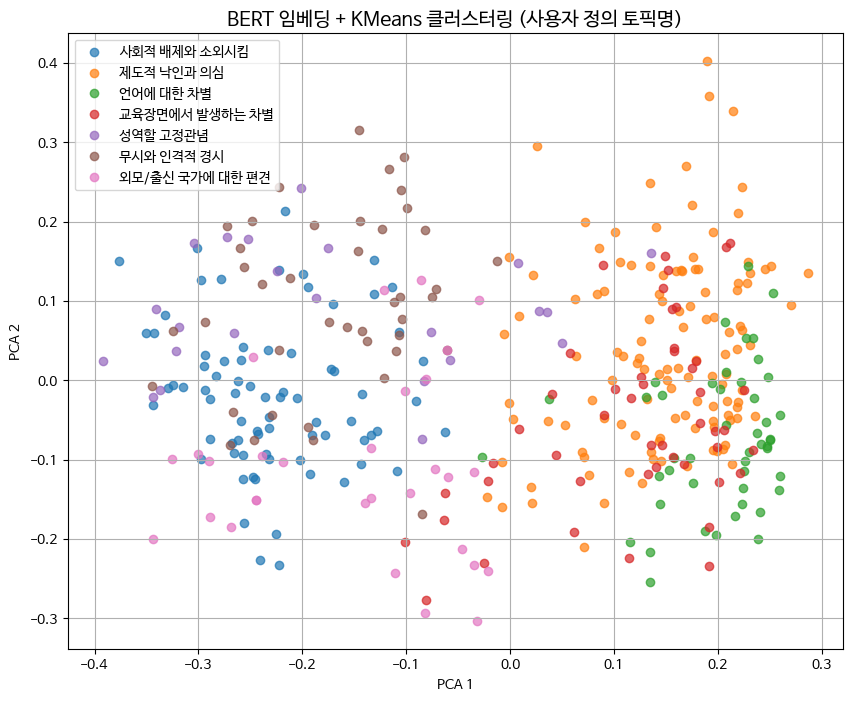

In [9]:
import matplotlib.pyplot as plt

topic_labels = {
    0: "외모/출신 국가에 대한 편견",
    1: "교육장면에서 발생하는 차별",
    2: "언어에 대한 차별",
    3: "무시와 인격적 경시",
    4: "사회적 배제와 소외시킴",
    5: "제도적 낙인과 의심",
    6: "성역할 고정관념"
}

plt.figure(figsize=(10, 8))
for topic_num in df['토픽번호'].unique():
    subset = df[df['토픽번호'] == topic_num]
    plt.scatter(subset['x'], subset['y'], label=topic_labels[topic_num], alpha=0.7)

plt.title("BERT 임베딩 + KMeans 클러스터링 (사용자 정의 토픽명)", fontsize=14)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 문장 → 원문 리스트
original_sentences = df["원자료"].tolist()

# 각 토픽별 대표 문장 추출
for topic_idx in range(7):
    print(f"\n🧩 토픽 {topic_idx} 대표 문장:")

    # 클러스터 중심과 전체 문장의 유사도 계산
    center_vector = kmeans.cluster_centers_[topic_idx].reshape(1, -1)
    sims = cosine_similarity(center_vector, embeddings)[0]

    # 해당 토픽에 속한 문장 중 유사도 높은 순
    topic_sentences_idx = np.where(labels == topic_idx)[0]
    top_idxs = topic_sentences_idx[np.argsort(sims[topic_sentences_idx])[::-1][:5]]

    for idx in top_idxs:
        print(f"- {original_sentences[idx]}")


🧩 토픽 0 대표 문장:
- 사소한 부분에서 그런 것들이 많긴 한데 일을 할 때도 일을 할 때 같이 이제 얘기를 하면서 얘는 얘는 중국인이라서 그런 걸 잘 모르지 않아 막 이런 식으로 약간 얘기를 할 때. 이해 못할 수도 있는 건데 굳이 이제 외국인이라서 중국인이라서 이해를 못할 수 있고, 중국에서는 그래 그렇게 해 약간 이런 식으로 약간 얘기를 할 때 중국도 되게 다른 나라도 그렇지만 중국도 되게 크고 사람마다 삶의 방식이 다른데 그것 때문에 그렇다고 인지를 하는 것들이 되게 불편함을 주는 거죠. 중국 사람들은 이렇게 좀 아까 얘기한 것처럼 가리지 않고 잘 먹는다, 그런 것도 있고 그리고 되게 많았었는데 갑자기 생각이 안 나네.. 그리고 그러니까 약간 좀 더럽다는 그런 느낌 그런 거 잘 안 씻는 그런 게 있다면서 하고 물어볼 때 그런 것들도 그렇고 그리고 뭔가
- 이 질문지를 먼저 면접 인터뷰 전에 미리 받았었는데 폭력 따돌림 희롱은 확실히 없었던 것 같고 언어적 차별 경험 예를 들어 중국 사람들이 얘기를 할 때 되게 높은 소리로 얘기를 얘기를 해서 싸우는 것 같다. 이랬는데 제가 뭔가 누군가랑 이렇게 중국에 같이 다시 윗분들이랑 모시고 한국인 윗분들을 모시고 중국에 출장 갔을 때 제가 이렇게 중국어로 통화할 때면 영준 쌤도 중국인이구나 이런 얘기를 들었던 그게 그게
- 근데 직장 경우에는 저는 그런 거 별로 없고 근데 만약에 밖에서 만나는 사람 경우에는 가끔씩 그럴 수도 있어요. 왜냐면 제 외모 보면 딱 봐도 중국 사람 같다고 생각하는데, 근데 어느 나라 사람이라고 물어볼 때 저는 홍콩이라고 했더니, 그 사람들이 홍콩이 어디인지 모를 수 있어요. 그래서 다 중국이라고 생각하는데. 그래서 사람들이 좀 그런 인식이 좀 있잖아요. 중국은 뭐 좀 못 살 수도 있고 학벌 좀 낫다고 생각하는 분 되게 많아요. 근데 솔직히 제 학벌이 한국사람보다 좋거든요. 공부도 계속 영어 공부했는데 영어도 잘 하거든요. 수업도 다 영어로 진행하는데, 근데 그런 사람들이 다 안 믿어

In [11]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 30.3 MB/s eta 0:00:00


In [12]:
from konlpy.tag import Okt
okt = Okt()

In [13]:
stopwords = set([
    '그', '이', '저', '것', '등', '때', '중', '누구', '무엇',
    '하다', '되다', '있다', '없다', '받다', '가다', '오다', '보다', '주다', '말하다', '들다',
    '계속', '이제', '지금', '예전', '요즘', '거의', '좀', '많이', '더', '다시', '별로',
    '그리고', '그래서', '그런데', '하지만', '그러니까', '때문', '이런', '그런', '어떤', '같다',
    '나', '내', '너', '우리', '당신', '그녀', '그들', '사람', '모두',
    '여기', '저기', '거기', '안', '밖', '위', '아래', '그곳', '방향',
    '도', '는', '만', '과', '와', '보다', '까지', '부터', '으로', '에게', '이랑', '밖에', '조차',
    '정도', '경우', '내용', '문제', '이야기', '모습', '상황', '자신',
    '음', '응', '오', '어휴', '허', '아이고', '에휴', '웃음', '그떄', '그다음', '아마',
    '...', '…', '“', '”', '‘', '’', '-', '--', '―',
    '그냥', '진짜', '완전', '약간', '어떻게', '뭐', '딱', '막', '또', '또는',
    '해도', '생각', '중략', '가지', '조금', '다문화', '이제',
    '중국', '일본', '한국', '우즈베키스탄', '베트남', '태국', '몽골', '몽고',
    '자기', '그때', '그거', '수도', '그게', '여러', '무슨', '네네', '나이', '어디',
    '먼저', '대부분', '나중', '대해', '그것', '뭔가', '전혀', '저희', '만약', '이주', '나가야',
   '다른', '항상',  '얘기', '나라', '부분', '선생님'
])
standardization_dict = {
      "아빠": "남편", "여자":"여성", "아기":"아이",
    "한국말": "한국어", "시엄마": "시어머니", "어머니": "시어머니", "대한민국": "한국",
    "외국": "외국인", "외국사람": "외국인",
    "차별적": "차별",
    "무시당함": "무시", "무시함": "무시",
    "편견들": "편견", "회사":"직장", "업무":"직장", "일":"직장","회사생활":"직장",
    "말": "언어",
    "한국사람": "한국인"
}


In [14]:
def extract_keywords(text):
    words = text.split()
    standardized_words = [standardization_dict.get(w, w) for w in words]

    keywords = []
    for word in standardized_words:
        nouns = okt.nouns(word)
        for noun in nouns:
            if noun not in stopwords and len(noun) > 1:
                keywords.append(noun)
    return keywords

In [15]:
from collections import Counter

print("\n📌 각 토픽별 상위 키워드 (형태소 + 불용어 제거 + 표준화):")

for topic_idx in range(7):
    topic_docs = [
        extract_keywords(text)
        for i, text in enumerate(original_sentences)
        if labels[i] == topic_idx
    ]
    all_words = [word for doc in topic_docs for word in doc]

    if not all_words:
        print(f"\n🧩 토픽 {topic_idx}: 키워드 없음")
        continue

    top_words = Counter(all_words).most_common(10)
    print(f"\n🧩 토픽 {topic_idx} 키워드:")
    for word, freq in top_words:
        print(f"- {word} ({freq})")


📌 각 토픽별 상위 키워드 (형태소 + 불용어 제거 + 표준화):

🧩 토픽 0 키워드:
- 중국인 (20)
- 결혼 (20)
- 외국인 (19)
- 질문 (16)
- 직장 (14)
- 친구 (13)
- 차별 (13)
- 느낌 (12)
- 차이 (11)
- 사실 (11)

🧩 토픽 1 키워드:
- 아이 (115)
- 엄마 (36)
- 외국인 (34)
- 언어 (27)
- 공부 (24)
- 수업 (23)
- 친구 (23)
- 마음 (23)
- 직장 (22)
- 학교 (21)

🧩 토픽 2 키워드:
- 아이 (32)
- 엄마 (16)
- 아들 (15)
- 차별 (13)
- 부모님 (12)
- 마음 (12)
- 언어 (12)
- 가끔 (11)
- 남편 (10)
- 학생 (10)

🧩 토픽 3 키워드:
- 아이 (83)
- 엄마 (52)
- 남편 (37)
- 학교 (37)
- 한국어 (30)
- 외국인 (29)
- 언어 (28)
- 아기 (27)
- 결혼 (27)
- 영어 (19)

🧩 토픽 4 키워드:
- 외국인 (49)
- 한국어 (36)
- 남편 (35)
- 한국인 (34)
- 차별 (34)
- 친구 (31)
- 직장 (29)
- 언어 (26)
- 결혼 (22)
- 처음 (22)

🧩 토픽 5 키워드:
- 남편 (76)
- 외국인 (62)
- 엄마 (55)
- 차별 (29)
- 직장 (28)
- 아이 (27)
- 결혼 (26)
- 친구 (24)
- 여성 (24)
- 직원 (24)

🧩 토픽 6 키워드:
- 여성 (73)
- 여자 (28)
- 남자 (28)
- 차별 (25)
- 외국인 (24)
- 결혼 (19)
- 직장 (15)
- 혼자 (14)
- 사회 (12)
- 기회 (11)
